In [1]:
import numpy as np
from numpy import save
from numpy import load
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt

import torch
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import lava.lib.dl.slayer as slayer
from tqdm import tqdm
import os
from loss import DECOLLELoss
from assistant_fixed import HybridAssistant
from torch.nn.functional import one_hot

## Dataset creation 
### This makes and SAVES the dataset, we want to keep the SAME one across all our training

In [2]:
np.random.seed(0)

n_train = 5000 # 1,000,000 in the original paper
n_val = 1000 # 8192 in the original paper
n_prot = 20 # 200 prototypes in the original paper
n_class = 10 # 100 classes in the original paper 

layer_sizes = [50, 500, 50, 2500] # These are same as the original

n_ors = layer_sizes[0] # 50 olfactory receptors
n_timepoints = 150 # Number of timepoints per sample in the dataset
batch_size = 256

class ORDataset(Dataset):
    """Dataset operating on olfactory receptors"""

    def __init__(self, input, labels):
        """
        Arguments:
            dataset (np.ndarray): the olfactory receptor dataset, in the shape
                of (n_ors, n_timepoints, n_samples)
        """
        self.input = input
        self.labels = labels  

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return (self.input[:,:,idx], self.labels[idx])


In [3]:
# Creating the dataset

# The "prototype smells" for each class; the prototype closest to the 
# smell in euclidean space determines the smell's class (BUT NOT DIRECTLY)
prototypes = np.random.uniform(0,1, (n_prot, n_ors)).astype(np.float32)

train_x = np.random.uniform(0,1, (n_train, n_ors)).astype(np.float32)
val_x = np.random.uniform(0,1, (n_val, n_ors)).astype(np.float32)

def get_labels(prototypes, odors):
    ''' The prototype with the shortest Euclidean distance to each smell
        becomes the smell's label'''
    # Calculating euclidean distances for each odor, across all prototypes
    dist = euclidean_distances(prototypes, odors)
    # Finding the prototype with the minimum distance to each smell, and partitioning
    # into the ACTUAL CLASS (just assume they're put next to each other)
    return np.argmin(dist, axis=0)//2

train_y = get_labels(prototypes, train_x).astype(np.int32)
val_y = get_labels(prototypes, val_x).astype(np.int32)

# Stacking the input to 300 timepoints
train_x = train_x.transpose()
val_x = val_x.transpose()
train_x = np.repeat(train_x[:, np.newaxis, :], n_timepoints, axis=1)
val_x = np.repeat(val_x[:, np.newaxis, :], n_timepoints, axis=1)
train_x = torch.tensor(train_x)
val_x = torch.tensor(val_x)

# Saving datasets 
data_folder = os.path.join(os.getcwd(),'Data')
os.makedirs(data_folder, exist_ok=True)

save(os.path.join(data_folder, 'train_x'), train_x)
save(os.path.join(data_folder, 'train_y'), train_y)
save(os.path.join(data_folder, 'val_x'), val_x)
save(os.path.join(data_folder, 'val_y'), val_y)

## Loading pre-saved dataset and putting into dataloader

In [4]:
data_folder = 'Data'
train_x = load(os.path.join(data_folder, 'train_x.npy'))
train_y = load(os.path.join(data_folder, 'train_y.npy'))
val_x = load(os.path.join(data_folder, 'val_x.npy'))
val_y = load(os.path.join(data_folder, 'val_y.npy'))

train_dataset = ORDataset(train_x, train_y)
test_dataset = ORDataset(val_x, val_y)

training_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testing_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Network definition + initialization

In [3]:
class HybridNetwork(torch.nn.Module):
    def __init__(self, layer_sizes, 
                 n_class, stdp_learning_rate, 
                 stdp_tau_combined, train_hybrid, burn_in=0):
        
        super(HybridNetwork, self).__init__()

        self.burn_in = burn_in
        self.stdp_learning_rate = stdp_learning_rate
        self.stdp_tau_combined = stdp_tau_combined
        self.layer_sizes = layer_sizes
        self.train_hybrid = train_hybrid

        # Input neuron parameters, threshold set to 1 as per course guidelines
        input_neuron_parameters = {
            'threshold': 1.,
            'current_decay': 0.25,
            'voltage_decay': 0.03,
            'tau_grad': 0.03,
            'scale_grad': 3.,
            'requires_grad': True,
            'persistent_state': True
        }
        # Default values in SLAYER and DECOLLE notebooks
        neuron_parameters = {
            'threshold': 1.25,
            'current_decay': 0.25,
            'voltage_decay': 0.03,
            'tau_grad': 0.03,
            'scale_grad': 3.,
            'requires_grad': True,
            'persistent_state': True
        }

        # Defining layers. Input layer defined separately to make dataset work.
        blocks = [slayer.block.cuba.Dense(
            input_neuron_parameters, layer_sizes[0], layer_sizes[1], weight_norm=False)]
        
        for i in range(1, len(layer_sizes)-1):
            blocks.append(slayer.block.cuba.Dense(
                neuron_parameters, layer_sizes[i], 
                layer_sizes[i+1], weight_norm=False))
            
        self.blocks = torch.nn.ModuleList(blocks)

        # Removing gradient dependence for the STDP block if training in hybrid
        # mode. 
        if self.train_hybrid: 
            self.blocks[-1].synapse.weight.requires_grad=False 
            
        # Defining random readouts for each layer except the input. 
    
        readout_layers = []
        for layer_size in self.layer_sizes[1:]:
                readout_layers.append(torch.nn.Linear(layer_size, n_class, bias=False))
        self.readout_layers = torch.nn.ModuleList(readout_layers)

        # If training in hybrid mode, last readout layer needs gradient
        # computation, whereas none of the readouts need this with 
        # standard DECOLLE
        for readout_layer in self.readout_layers:
            readout_layer.weight.requires_grad = False
        if self.train_hybrid:
            self.readout_layers[-1].weight.requires_grad = True
    
    def forward(self, spike):
        # First we pass the input through all of the layers and get the
        # corresponding output at each layer, then we iterate through
        # these layers' linear readout layers as well. Readout layers
        # are returned for all layers, with the pre-specified gradient 
        # dependencies determining what happens when these readouts are used
        # for gradient descent. 
        
        spike.requires_grad_()
        all_spikes = [] # all spikes within the model
        readouts = []
        voltages = []
        spike_counts = []

        for i, layer in enumerate(self.blocks):
            # Getting voltage at each postsynaptic neuron corresponding to input
            z = layer.synapse(spike.detach())
            _, voltage = layer.neuron.dynamics(z)
            # Getting the spikes that result from the voltage at these neurons
            spike = layer.neuron.spike(voltage)

            # If training in hybrid mode, we don't want any gradient accumulation
            # for the spikes created within the last block
            if self.train_hybrid and i == 2:
                all_spikes.append(spike.detach())
            else:
                all_spikes.append(spike)

            voltages.append(voltage)
            spike_counts.append(torch.mean(spike.detach()))
        
        for readout_layer, spike in zip(self.readout_layers, all_spikes):
            # Getting a linear readout of the layer
            readout = []
            for t in range(spike.shape[-1]):
                readout.append(readout_layer(spike[..., t]))
            readouts.append(torch.stack(readout, dim=-1))
        
        return all_spikes, readouts, voltages, spike_counts
    
    def reset_(self):
        # Resetting the state of the network
        for layer in self.blocks:
            layer.neuron.current_state[:] = 0
            layer.neuron.voltage_state[:] = 0
    
    def init_state(self, inputs, burn_in=None):
        # Resets the network state, and applies an initial burn-in period
        # by passing the first few timepoints of the input through the network
        self.reset_()
        if burn_in is None:
            burn_in = self.burn_in
        self.forward(inputs[..., :burn_in])

        return inputs[..., :burn_in] 
    
    def plot_weights(self, block_idx):
        plt.figure()
        layer_params = self.blocks[block_idx].synapse.weight.data
        weight_matrix = np.squeeze(layer_params.numpy())
        plt.imshow(weight_matrix, aspect='auto')
        plt.colorbar(shrink = 0.8, label = 'Weight')
        plt.title(f'Weights for block {block_idx}')
        plt.xlabel('Presynaptic neurons')
        plt.ylabel('Postsynaptic neurons')
    
    def print_weights(self, block_idx):
        print(np.squeeze(self.blocks[block_idx].synapse.weight.data.numpy()))

    
# Initializing everything
trained_folder = 'Trained'
os.makedirs(trained_folder, exist_ok=True)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

stdp_learning_rate = 0.000007 
stdp_tau_combined = -2    

hybrid_network = HybridNetwork(
    layer_sizes, n_class, stdp_learning_rate, 
    stdp_tau_combined, train_hybrid=True, burn_in=50).to(device)

error = DECOLLELoss(torch.nn.SmoothL1Loss, reduction='mean')
optimizer = torch.optim.Adam(hybrid_network.parameters(), lr=0.0001)

stats = slayer.utils.LearningStats()
assistant = HybridAssistant(hybrid_network, error, optimizer, stats,
                             classifier=slayer.classifier.Rate.predict, count_log=True)

## Training + visualizations

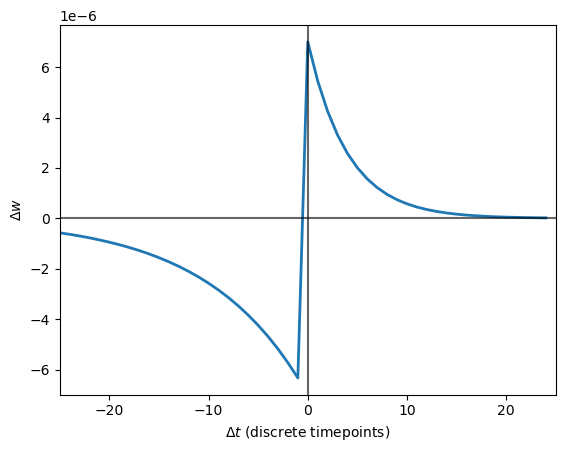

In [5]:
# Can visualize the function which the assistant will use. The parameters 
# stdp_learning_rate and stdp_tau_combined will influence this!
assistant.plot_stdp_curve()
plt.savefig('learning_rule.png', bbox_inches="tight", dpi=300)

## 1:1 ratio

In [6]:
layer_sizes = [50, 500, 50, 50] 

hybrid_network = HybridNetwork(
    layer_sizes, n_class, stdp_learning_rate, 
    stdp_tau_combined, train_hybrid=True, burn_in=50).to(device)

error = DECOLLELoss(torch.nn.SmoothL1Loss, reduction='mean')
optimizer = torch.optim.Adam(hybrid_network.parameters(), lr=0.0001)

stats = slayer.utils.LearningStats()
assistant = HybridAssistant(hybrid_network, error, optimizer, stats,
                             classifier=slayer.classifier.Rate.predict, count_log=True)

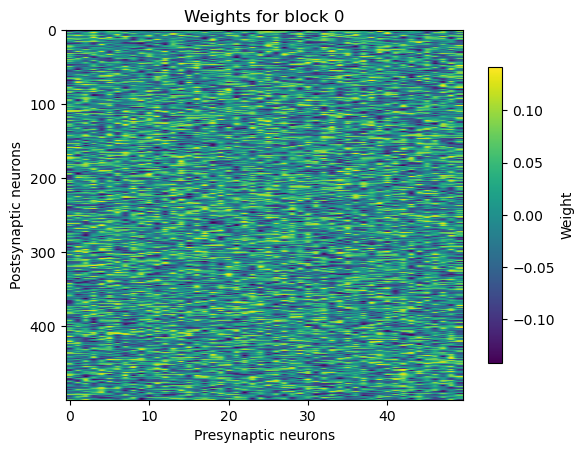

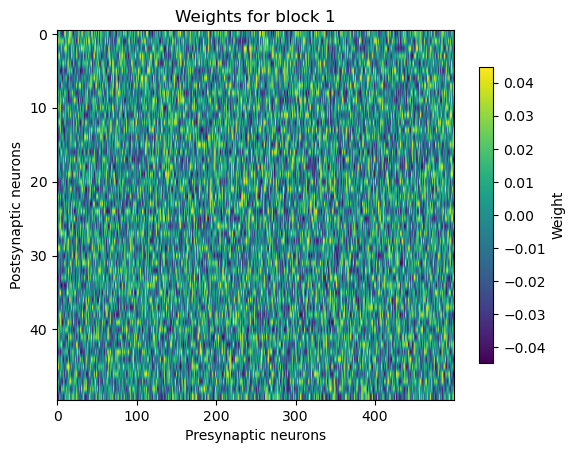

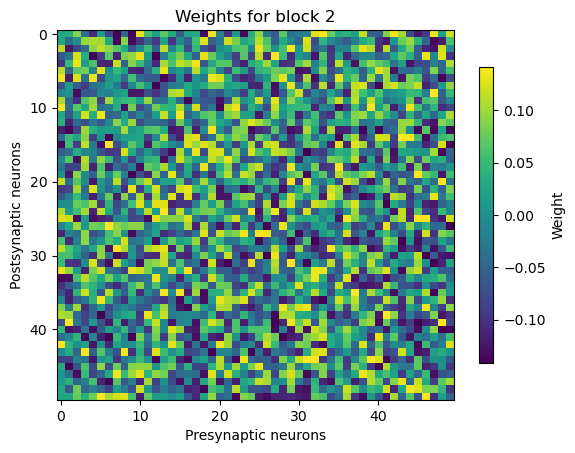

In [7]:
# Easy visualization of what's going on with the network weights.
# These are untrained!
for i in range(len(layer_sizes)-1):
    hybrid_network.plot_weights(i)

In [8]:
trained_folder = 'Trained/1_to_1'
os.makedirs(trained_folder, exist_ok=True)

epochs = 30
for epoch_i, epoch in enumerate(range(epochs)):

    # Training
    train_iter = iter(training_loader)
    for (inputs, label) in tqdm(train_iter): 
        output, count = assistant.train_hybrid(
            inputs, one_hot(label.to(torch.int64), num_classes=n_class), 
            ignore_zeros=False)
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
    
    # Testing
    test_iter = iter(testing_loader) 
    for (inputs, label) in tqdm(test_iter):
        output, count = assistant.test(
            inputs, one_hot(label.to(torch.int64), num_classes=n_class))
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')

    # Saving network if best performance so far
    # if stats.testing.best_accuracy:
    torch.save(hybrid_network.state_dict(), trained_folder + f'/network_1to1_30epochs_epoch_{epoch_i}.pt')
    stats.update()
    stats.save(path= trained_folder+ "/")

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


[Epoch  0/30] Train loss =    12.91305                          accuracy = 0.17160 

100%|██████████| 4/4 [00:01<00:00,  2.05it/s]


[Epoch  0/30] Train loss =    12.91305                          accuracy = 0.17160  | Test  loss =     8.73366                          accuracy = 0.07000 

100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


[Epoch  1/30] Train loss =     7.98852 (min =    12.91305)     accuracy = 0.18420 (max = 0.17160) 

100%|██████████| 4/4 [00:02<00:00,  1.96it/s]


[Epoch  1/30] Train loss =     7.98852 (min =    12.91305)     accuracy = 0.18420 (max = 0.17160)  | Test  loss =     8.15803 (min =     8.73366)     accuracy = 0.11000 (max = 0.07000) 

100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


[Epoch  2/30] Train loss =     7.77900 (min =     7.98852)     accuracy = 0.19620 (max = 0.18420) 

100%|██████████| 4/4 [00:02<00:00,  1.98it/s]


[Epoch  2/30] Train loss =     7.77900 (min =     7.98852)     accuracy = 0.19620 (max = 0.18420)  | Test  loss =     7.84862 (min =     8.15803)     accuracy = 0.21800 (max = 0.11000) 

100%|██████████| 20/20 [00:18<00:00,  1.11it/s]


[Epoch  3/30] Train loss =     7.56914 (min =     7.77900)     accuracy = 0.19740 (max = 0.19620) 

100%|██████████| 4/4 [00:02<00:00,  1.99it/s]


[Epoch  3/30] Train loss =     7.56914 (min =     7.77900)     accuracy = 0.19740 (max = 0.19620)  | Test  loss =     7.98377 (min =     7.84862)     accuracy = 0.20900 (max = 0.21800) 

 25%|██▌       | 5/20 [00:05<00:16,  1.07s/it]


KeyboardInterrupt: 

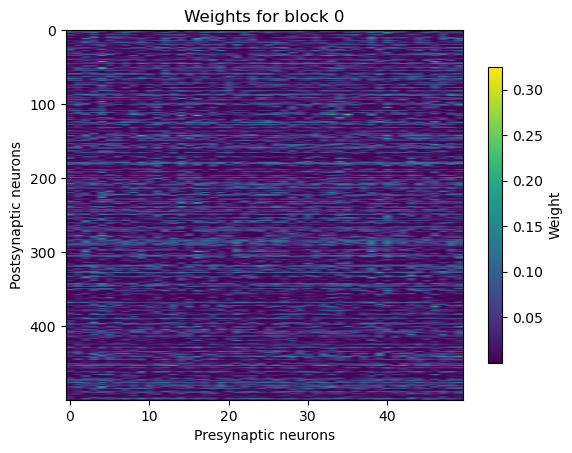

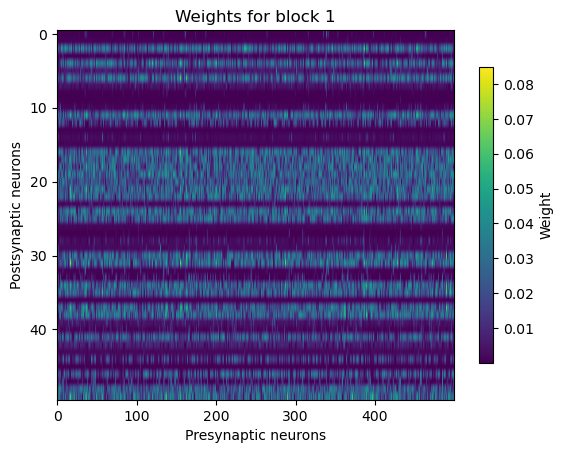

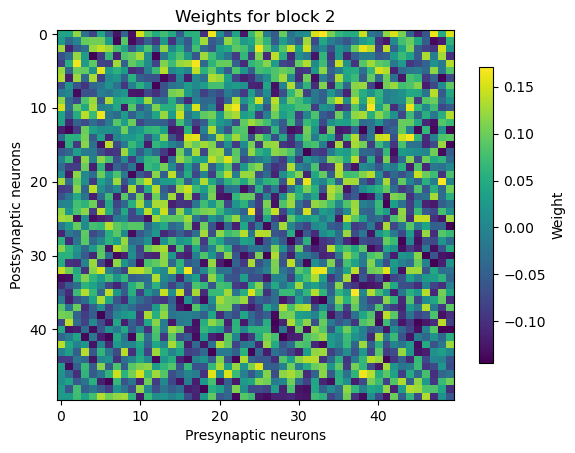

In [9]:
for i in range(len(layer_sizes)-1):
    hybrid_network.plot_weights(i)

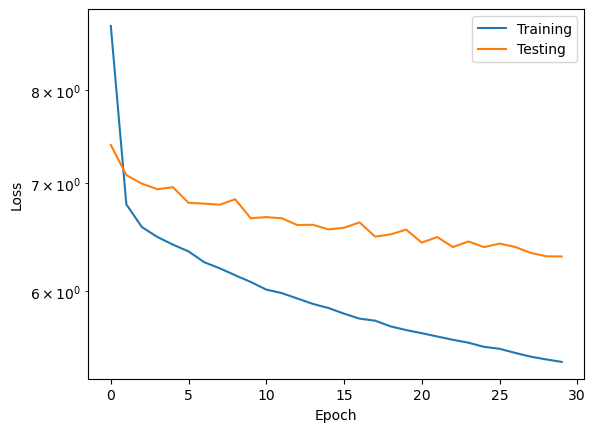

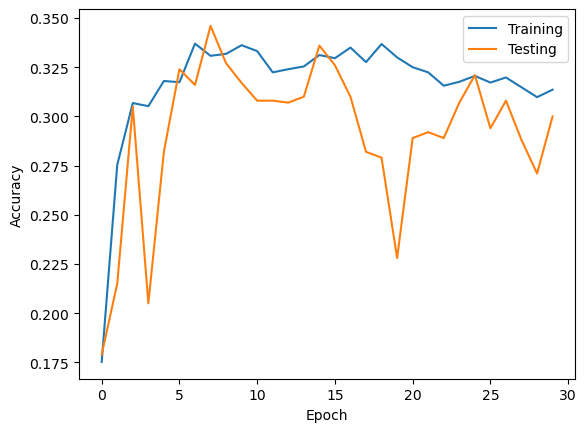

In [9]:
stats.plot(path=trained_folder+ "/")

## 1:10 ratio

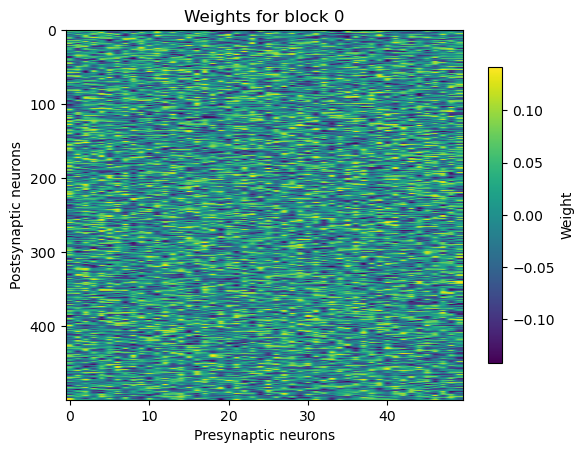

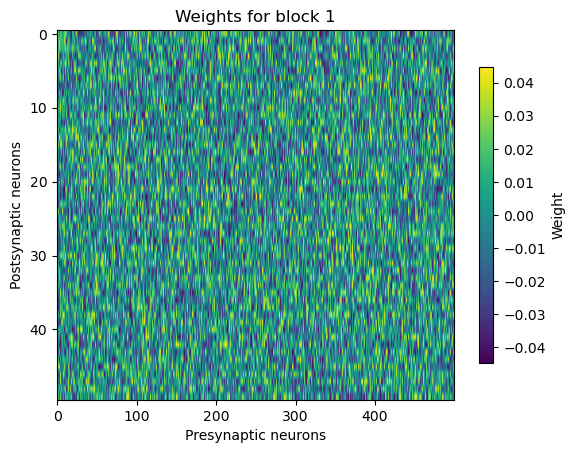

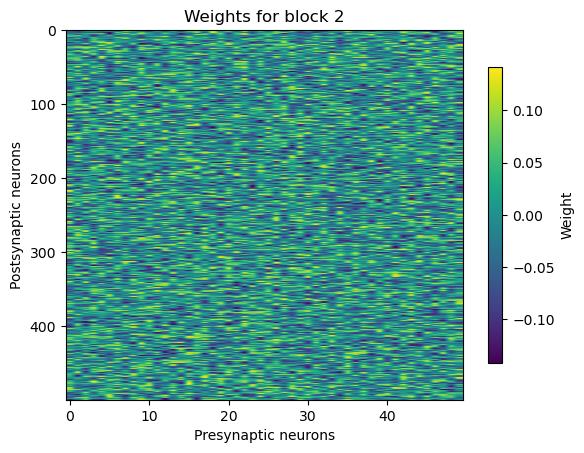

In [10]:
train_x = load(os.path.join(data_folder, 'train_x.npy'))
train_y = load(os.path.join(data_folder, 'train_y.npy'))
val_x = load(os.path.join(data_folder, 'val_x.npy'))
val_y = load(os.path.join(data_folder, 'val_y.npy'))

train_dataset = ORDataset(train_x, train_y)
test_dataset = ORDataset(val_x, val_y)

training_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testing_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

layer_sizes = [50, 500, 50, 500]   

hybrid_network = HybridNetwork(
    layer_sizes, n_class, stdp_learning_rate, 
    stdp_tau_combined, train_hybrid=True, burn_in=50).to(device)

error = DECOLLELoss(torch.nn.SmoothL1Loss, reduction='mean')
optimizer = torch.optim.Adam(hybrid_network.parameters(), lr=0.0001)

stats = slayer.utils.LearningStats()
assistant = HybridAssistant(hybrid_network, error, optimizer, stats,
                             classifier=slayer.classifier.Rate.predict, count_log=True)

for i in range(len(layer_sizes)-1):
    hybrid_network.plot_weights(i)

In [11]:
trained_folder = 'Trained/1_to_10'
os.makedirs(trained_folder, exist_ok=True)

epochs = 30
for epoch_i, epoch in enumerate(range(epochs)):

    # Training
    train_iter = iter(training_loader)
    for (inputs, label) in tqdm(train_iter): 
        output, count = assistant.train_hybrid(
            inputs, one_hot(label.to(torch.int64), num_classes=n_class), 
            ignore_zeros=False)
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
    
    # Testing
    test_iter = iter(testing_loader) 
    for (inputs, label) in tqdm(test_iter):
        output, count = assistant.test(
            inputs, one_hot(label.to(torch.int64), num_classes=n_class))
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')

    # Saving network if best performance so far
    # if stats.testing.best_accuracy:
    torch.save(hybrid_network.state_dict(), trained_folder + f'/network_1to10_30epochs_epoch_{epoch_i}.pt')
    stats.update()
    stats.save(path= trained_folder+ "/")

100%|██████████| 20/20 [00:52<00:00,  2.63s/it]


[Epoch  0/30] Train loss =     8.85164                          accuracy = 0.25120 

100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


[Epoch  0/30] Train loss =     8.85164                          accuracy = 0.25120  | Test  loss =     7.25349                          accuracy = 0.27100 

100%|██████████| 20/20 [00:52<00:00,  2.64s/it]


[Epoch  1/30] Train loss =     6.66562 (min =     8.85164)     accuracy = 0.36680 (max = 0.25120) 

100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


[Epoch  1/30] Train loss =     6.66562 (min =     8.85164)     accuracy = 0.36680 (max = 0.25120)  | Test  loss =     7.02834 (min =     7.25349)     accuracy = 0.35000 (max = 0.27100) 

100%|██████████| 20/20 [00:55<00:00,  2.78s/it]


[Epoch  2/30] Train loss =     6.50924 (min =     6.66562)     accuracy = 0.40200 (max = 0.36680) 

100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


[Epoch  2/30] Train loss =     6.50924 (min =     6.66562)     accuracy = 0.40200 (max = 0.36680)  | Test  loss =     6.87522 (min =     7.02834)     accuracy = 0.36600 (max = 0.35000) 

100%|██████████| 20/20 [00:57<00:00,  2.86s/it]


[Epoch  3/30] Train loss =     6.41489 (min =     6.50924)     accuracy = 0.42440 (max = 0.40200) 

100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


[Epoch  3/30] Train loss =     6.41489 (min =     6.50924)     accuracy = 0.42440 (max = 0.40200)  | Test  loss =     6.82367 (min =     6.87522)     accuracy = 0.41200 (max = 0.36600) 

100%|██████████| 20/20 [00:55<00:00,  2.80s/it]


[Epoch  4/30] Train loss =     6.31695 (min =     6.41489)     accuracy = 0.43940 (max = 0.42440) 

100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


[Epoch  4/30] Train loss =     6.31695 (min =     6.41489)     accuracy = 0.43940 (max = 0.42440)  | Test  loss =     6.88716 (min =     6.82367)     accuracy = 0.35300 (max = 0.41200) 

100%|██████████| 20/20 [00:55<00:00,  2.77s/it]


[Epoch  5/30] Train loss =     6.26079 (min =     6.31695)     accuracy = 0.44440 (max = 0.43940) 

100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


[Epoch  5/30] Train loss =     6.26079 (min =     6.31695)     accuracy = 0.44440 (max = 0.43940)  | Test  loss =     6.81265 (min =     6.82367)     accuracy = 0.37700 (max = 0.41200) 

100%|██████████| 20/20 [00:55<00:00,  2.79s/it]


[Epoch  6/30] Train loss =     6.16909 (min =     6.26079)     accuracy = 0.45020 (max = 0.44440) 

100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


[Epoch  6/30] Train loss =     6.16909 (min =     6.26079)     accuracy = 0.45020 (max = 0.44440)  | Test  loss =     6.70553 (min =     6.81265)     accuracy = 0.38900 (max = 0.41200) 

100%|██████████| 20/20 [00:55<00:00,  2.79s/it]


[Epoch  7/30] Train loss =     6.10025 (min =     6.16909)     accuracy = 0.45960 (max = 0.45020) 

100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


[Epoch  7/30] Train loss =     6.10025 (min =     6.16909)     accuracy = 0.45960 (max = 0.45020)  | Test  loss =     6.65584 (min =     6.70553)     accuracy = 0.39300 (max = 0.41200) 

100%|██████████| 20/20 [00:57<00:00,  2.86s/it]


[Epoch  8/30] Train loss =     6.03913 (min =     6.10025)     accuracy = 0.46080 (max = 0.45960) 

100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


[Epoch  8/30] Train loss =     6.03913 (min =     6.10025)     accuracy = 0.46080 (max = 0.45960)  | Test  loss =     6.66461 (min =     6.65584)     accuracy = 0.40300 (max = 0.41200) 

100%|██████████| 20/20 [00:57<00:00,  2.87s/it]


[Epoch  9/30] Train loss =     6.00675 (min =     6.03913)     accuracy = 0.46060 (max = 0.46080) 

100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


[Epoch  9/30] Train loss =     6.00675 (min =     6.03913)     accuracy = 0.46060 (max = 0.46080)  | Test  loss =     6.79727 (min =     6.65584)     accuracy = 0.39300 (max = 0.41200) 

100%|██████████| 20/20 [00:56<00:00,  2.83s/it]


[Epoch 10/30] Train loss =     5.96513 (min =     6.00675)     accuracy = 0.46340 (max = 0.46080) 

100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


[Epoch 10/30] Train loss =     5.96513 (min =     6.00675)     accuracy = 0.46340 (max = 0.46080)  | Test  loss =     6.64284 (min =     6.65584)     accuracy = 0.39000 (max = 0.41200) 

100%|██████████| 20/20 [00:55<00:00,  2.78s/it]


[Epoch 11/30] Train loss =     5.90468 (min =     5.96513)     accuracy = 0.46840 (max = 0.46340) 

100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


[Epoch 11/30] Train loss =     5.90468 (min =     5.96513)     accuracy = 0.46840 (max = 0.46340)  | Test  loss =     6.64211 (min =     6.64284)     accuracy = 0.41000 (max = 0.41200) 

100%|██████████| 20/20 [00:56<00:00,  2.82s/it]


[Epoch 12/30] Train loss =     5.87035 (min =     5.90468)     accuracy = 0.46880 (max = 0.46840) 

100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


[Epoch 12/30] Train loss =     5.87035 (min =     5.90468)     accuracy = 0.46880 (max = 0.46840)  | Test  loss =     6.67977 (min =     6.64211)     accuracy = 0.39200 (max = 0.41200) 

100%|██████████| 20/20 [00:55<00:00,  2.79s/it]


[Epoch 13/30] Train loss =     5.82065 (min =     5.87035)     accuracy = 0.47100 (max = 0.46880) 

100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


[Epoch 13/30] Train loss =     5.82065 (min =     5.87035)     accuracy = 0.47100 (max = 0.46880)  | Test  loss =     6.59636 (min =     6.64211)     accuracy = 0.40500 (max = 0.41200) 

100%|██████████| 20/20 [00:55<00:00,  2.77s/it]


[Epoch 14/30] Train loss =     5.80205 (min =     5.82065)     accuracy = 0.48400 (max = 0.47100) 

100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


[Epoch 14/30] Train loss =     5.80205 (min =     5.82065)     accuracy = 0.48400 (max = 0.47100)  | Test  loss =     6.47142 (min =     6.59636)     accuracy = 0.43500 (max = 0.41200) 

100%|██████████| 20/20 [00:56<00:00,  2.85s/it]


[Epoch 15/30] Train loss =     5.76530 (min =     5.80205)     accuracy = 0.49340 (max = 0.48400) 

100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


[Epoch 15/30] Train loss =     5.76530 (min =     5.80205)     accuracy = 0.49340 (max = 0.48400)  | Test  loss =     6.53701 (min =     6.47142)     accuracy = 0.45200 (max = 0.43500) 

100%|██████████| 20/20 [00:57<00:00,  2.87s/it]


[Epoch 16/30] Train loss =     5.75993 (min =     5.76530)     accuracy = 0.48740 (max = 0.49340) 

100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


[Epoch 16/30] Train loss =     5.75993 (min =     5.76530)     accuracy = 0.48740 (max = 0.49340)  | Test  loss =     6.53789 (min =     6.47142)     accuracy = 0.45500 (max = 0.45200) 

100%|██████████| 20/20 [00:57<00:00,  2.88s/it]


[Epoch 17/30] Train loss =     5.73631 (min =     5.75993)     accuracy = 0.47860 (max = 0.49340) 

100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


[Epoch 17/30] Train loss =     5.73631 (min =     5.75993)     accuracy = 0.47860 (max = 0.49340)  | Test  loss =     6.51660 (min =     6.47142)     accuracy = 0.39600 (max = 0.45500) 

100%|██████████| 20/20 [00:56<00:00,  2.83s/it]


[Epoch 18/30] Train loss =     5.72008 (min =     5.73631)     accuracy = 0.47560 (max = 0.49340) 

100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


[Epoch 18/30] Train loss =     5.72008 (min =     5.73631)     accuracy = 0.47560 (max = 0.49340)  | Test  loss =     6.54565 (min =     6.47142)     accuracy = 0.44300 (max = 0.45500) 

100%|██████████| 20/20 [00:56<00:00,  2.83s/it]


[Epoch 19/30] Train loss =     5.69523 (min =     5.72008)     accuracy = 0.48280 (max = 0.49340) 

100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


[Epoch 19/30] Train loss =     5.69523 (min =     5.72008)     accuracy = 0.48280 (max = 0.49340)  | Test  loss =     6.45426 (min =     6.47142)     accuracy = 0.44900 (max = 0.45500) 

100%|██████████| 20/20 [00:56<00:00,  2.84s/it]


[Epoch 20/30] Train loss =     5.64624 (min =     5.69523)     accuracy = 0.48700 (max = 0.49340) 

100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


[Epoch 20/30] Train loss =     5.64624 (min =     5.69523)     accuracy = 0.48700 (max = 0.49340)  | Test  loss =     6.59710 (min =     6.45426)     accuracy = 0.40600 (max = 0.45500) 

100%|██████████| 20/20 [00:56<00:00,  2.84s/it]


[Epoch 21/30] Train loss =     5.65510 (min =     5.64624)     accuracy = 0.46760 (max = 0.49340) 

100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


[Epoch 21/30] Train loss =     5.65510 (min =     5.64624)     accuracy = 0.46760 (max = 0.49340)  | Test  loss =     6.47462 (min =     6.45426)     accuracy = 0.38100 (max = 0.45500) 

100%|██████████| 20/20 [00:57<00:00,  2.88s/it]


[Epoch 22/30] Train loss =     5.62734 (min =     5.64624)     accuracy = 0.46580 (max = 0.49340) 

100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


[Epoch 22/30] Train loss =     5.62734 (min =     5.64624)     accuracy = 0.46580 (max = 0.49340)  | Test  loss =     6.48995 (min =     6.45426)     accuracy = 0.41700 (max = 0.45500) 

100%|██████████| 20/20 [00:57<00:00,  2.87s/it]


[Epoch 23/30] Train loss =     5.60800 (min =     5.62734)     accuracy = 0.46460 (max = 0.49340) 

100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


[Epoch 23/30] Train loss =     5.60800 (min =     5.62734)     accuracy = 0.46460 (max = 0.49340)  | Test  loss =     6.45021 (min =     6.45426)     accuracy = 0.36800 (max = 0.45500) 

100%|██████████| 20/20 [00:57<00:00,  2.88s/it]


[Epoch 24/30] Train loss =     5.59498 (min =     5.60800)     accuracy = 0.44700 (max = 0.49340) 

100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


[Epoch 24/30] Train loss =     5.59498 (min =     5.60800)     accuracy = 0.44700 (max = 0.49340)  | Test  loss =     6.55409 (min =     6.45021)     accuracy = 0.42100 (max = 0.45500) 

100%|██████████| 20/20 [00:57<00:00,  2.88s/it]


[Epoch 25/30] Train loss =     5.56426 (min =     5.59498)     accuracy = 0.44920 (max = 0.49340) 

100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


[Epoch 25/30] Train loss =     5.56426 (min =     5.59498)     accuracy = 0.44920 (max = 0.49340)  | Test  loss =     6.44826 (min =     6.45021)     accuracy = 0.40000 (max = 0.45500) 

100%|██████████| 20/20 [00:57<00:00,  2.88s/it]


[Epoch 26/30] Train loss =     5.54384 (min =     5.56426)     accuracy = 0.45560 (max = 0.49340) 

100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


[Epoch 26/30] Train loss =     5.54384 (min =     5.56426)     accuracy = 0.45560 (max = 0.49340)  | Test  loss =     6.48569 (min =     6.44826)     accuracy = 0.33400 (max = 0.45500) 

100%|██████████| 20/20 [00:57<00:00,  2.87s/it]


[Epoch 27/30] Train loss =     5.52735 (min =     5.54384)     accuracy = 0.44940 (max = 0.49340) 

100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


[Epoch 27/30] Train loss =     5.52735 (min =     5.54384)     accuracy = 0.44940 (max = 0.49340)  | Test  loss =     6.39194 (min =     6.44826)     accuracy = 0.38700 (max = 0.45500) 

100%|██████████| 20/20 [00:57<00:00,  2.86s/it]


[Epoch 28/30] Train loss =     5.50667 (min =     5.52735)     accuracy = 0.44040 (max = 0.49340) 

100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


[Epoch 28/30] Train loss =     5.50667 (min =     5.52735)     accuracy = 0.44040 (max = 0.49340)  | Test  loss =     6.53217 (min =     6.39194)     accuracy = 0.38000 (max = 0.45500) 

100%|██████████| 20/20 [00:57<00:00,  2.85s/it]


[Epoch 29/30] Train loss =     5.51537 (min =     5.50667)     accuracy = 0.42400 (max = 0.49340) 

100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

[Epoch 29/30] Train loss =     5.51537 (min =     5.50667)     accuracy = 0.42400 (max = 0.49340)  | Test  loss =     6.43386 (min =     6.39194)     accuracy = 0.39500 (max = 0.45500) 

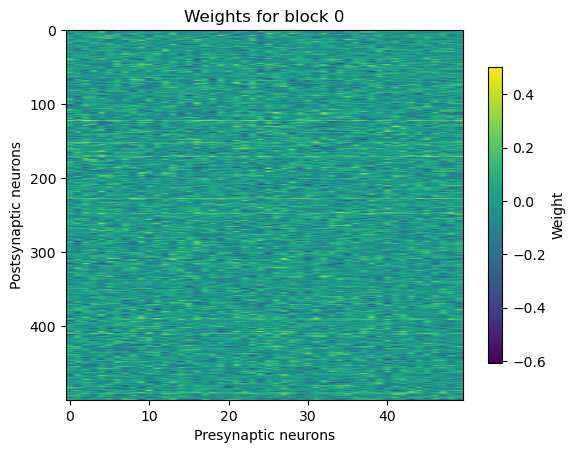

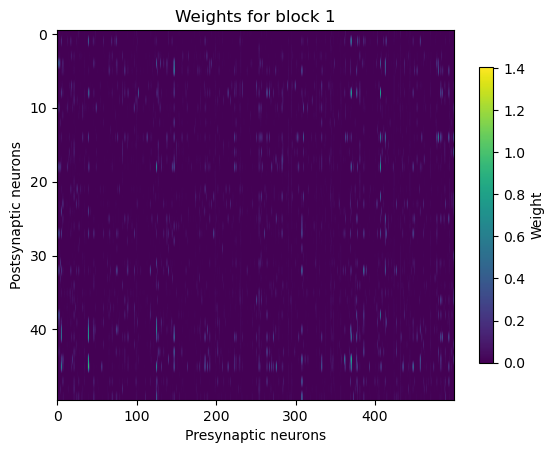

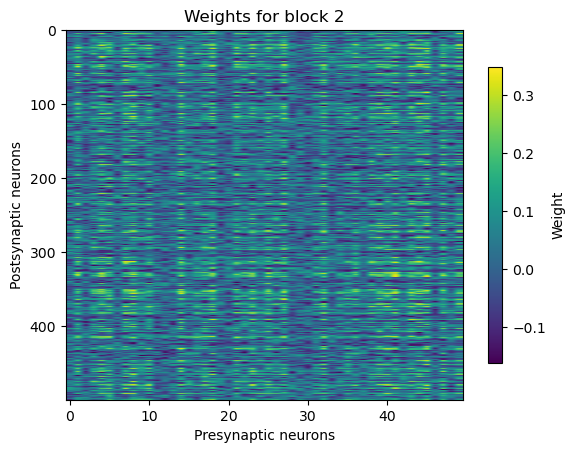

In [12]:
for i in range(len(layer_sizes)-1):
    hybrid_network.plot_weights(i)

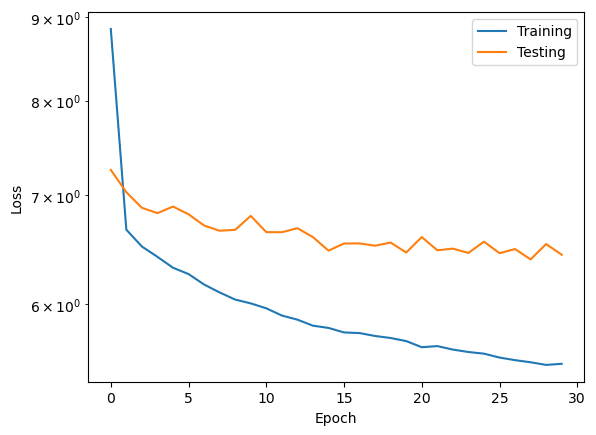

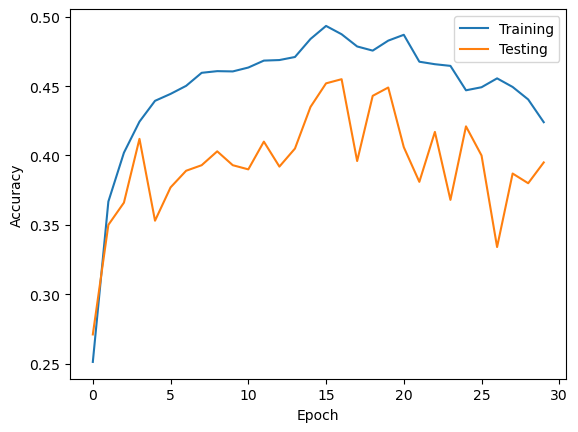

In [13]:
stats.plot(path=trained_folder+ "/")

## 1:100 ratio (not tested yet!)

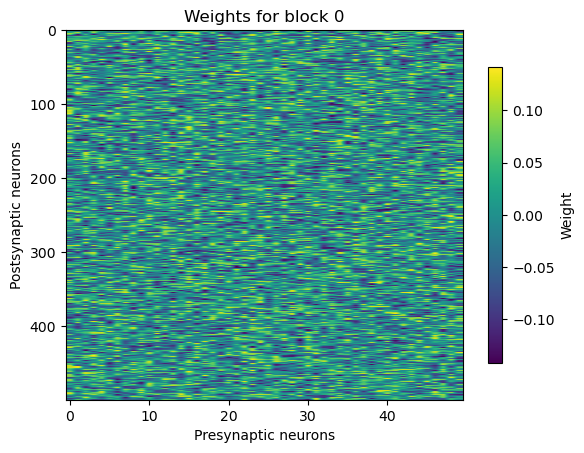

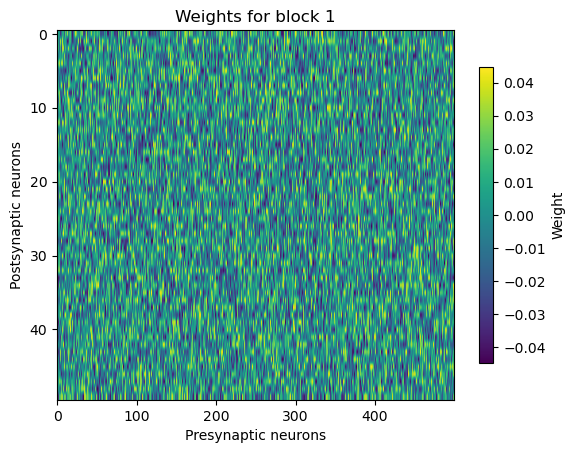

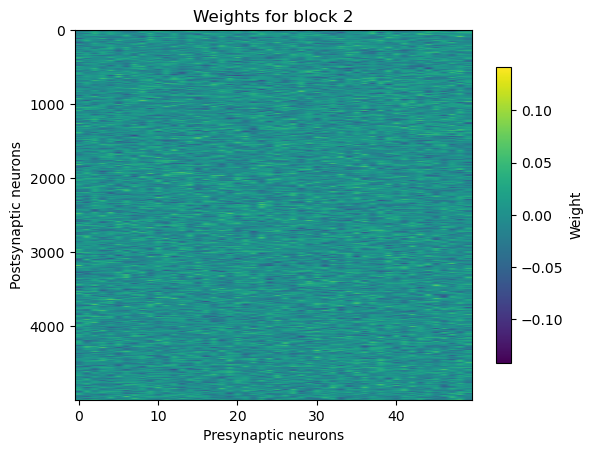

In [11]:
train_x = load(os.path.join(data_folder, 'train_x.npy'))
train_y = load(os.path.join(data_folder, 'train_y.npy'))
val_x = load(os.path.join(data_folder, 'val_x.npy'))
val_y = load(os.path.join(data_folder, 'val_y.npy'))

train_dataset = ORDataset(train_x, train_y)
test_dataset = ORDataset(val_x, val_y)

training_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testing_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

layer_sizes = [50, 500, 50, 5000]  

hybrid_network = HybridNetwork(
    layer_sizes, n_class, stdp_learning_rate, 
    stdp_tau_combined, train_hybrid=True, burn_in=50).to(device)

error = DECOLLELoss(torch.nn.SmoothL1Loss, reduction='mean')
optimizer = torch.optim.Adam(hybrid_network.parameters(), lr=0.0001)

stats = slayer.utils.LearningStats()
assistant = HybridAssistant(hybrid_network, error, optimizer, stats,
                             classifier=slayer.classifier.Rate.predict, count_log=True)

for i in range(len(layer_sizes)-1):
    hybrid_network.plot_weights(i)

In [12]:
trained_folder = 'Trained/1_to_100'
os.makedirs(trained_folder, exist_ok=True)

epochs = 30
for epoch_i, epoch in enumerate(range(epochs)):

    # Training
    train_iter = iter(training_loader)
    for (inputs, label) in tqdm(train_iter): 
        output, count = assistant.train_hybrid(
            inputs, one_hot(label.to(torch.int64), num_classes=n_class), ignore_zeros=False)
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
    
    # Testing
    test_iter = iter(testing_loader) 
    for (inputs, label) in tqdm(test_iter):
        output, count = assistant.test(
            inputs, one_hot(label.to(torch.int64), num_classes=n_class))
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')

    # Saving network if best performance so far
    # if stats.testing.best_accuracy:
    torch.save(hybrid_network.state_dict(), trained_folder + f'/network_1to100_30epochs_epoch_{epoch_i}.pt')
    stats.update()
    stats.save(path= trained_folder+ "/")

100%|██████████| 20/20 [07:33<00:00, 22.68s/it]


[Epoch  0/30] Train loss =    14.60505                          accuracy = 0.19260 

100%|██████████| 4/4 [00:12<00:00,  3.04s/it]


[Epoch  0/30] Train loss =    14.60505                          accuracy = 0.19260  | Test  loss =     9.54941                          accuracy = 0.16400 

100%|██████████| 20/20 [07:10<00:00, 21.52s/it]


[Epoch  1/30] Train loss =     8.05162 (min =    14.60505)     accuracy = 0.22140 (max = 0.19260) 

100%|██████████| 4/4 [00:12<00:00,  3.04s/it]


[Epoch  1/30] Train loss =     8.05162 (min =    14.60505)     accuracy = 0.22140 (max = 0.19260)  | Test  loss =     8.08583 (min =     9.54941)     accuracy = 0.22800 (max = 0.16400) 

100%|██████████| 20/20 [07:18<00:00, 21.93s/it]


[Epoch  2/30] Train loss =     7.59372 (min =     8.05162)     accuracy = 0.26280 (max = 0.22140) 

100%|██████████| 4/4 [00:11<00:00,  2.94s/it]


[Epoch  2/30] Train loss =     7.59372 (min =     8.05162)     accuracy = 0.26280 (max = 0.22140)  | Test  loss =     7.93818 (min =     8.08583)     accuracy = 0.18900 (max = 0.22800) 

100%|██████████| 20/20 [07:21<00:00, 22.06s/it]


[Epoch  3/30] Train loss =     7.48509 (min =     7.59372)     accuracy = 0.28380 (max = 0.26280) 

100%|██████████| 4/4 [00:11<00:00,  2.89s/it]


[Epoch  3/30] Train loss =     7.48509 (min =     7.59372)     accuracy = 0.28380 (max = 0.26280)  | Test  loss =     7.71101 (min =     7.93818)     accuracy = 0.25300 (max = 0.22800) 

100%|██████████| 20/20 [07:19<00:00, 21.99s/it]


[Epoch  4/30] Train loss =     7.41644 (min =     7.48509)     accuracy = 0.29580 (max = 0.28380) 

100%|██████████| 4/4 [00:12<00:00,  3.00s/it]


[Epoch  4/30] Train loss =     7.41644 (min =     7.48509)     accuracy = 0.29580 (max = 0.28380)  | Test  loss =     7.63134 (min =     7.71101)     accuracy = 0.25600 (max = 0.25300) 

100%|██████████| 20/20 [07:22<00:00, 22.15s/it]


[Epoch  5/30] Train loss =     7.28350 (min =     7.41644)     accuracy = 0.29800 (max = 0.29580) 

100%|██████████| 4/4 [00:12<00:00,  3.00s/it]


[Epoch  5/30] Train loss =     7.28350 (min =     7.41644)     accuracy = 0.29800 (max = 0.29580)  | Test  loss =     7.61281 (min =     7.63134)     accuracy = 0.24100 (max = 0.25600) 

100%|██████████| 20/20 [07:15<00:00, 21.80s/it]


[Epoch  6/30] Train loss =     7.27450 (min =     7.28350)     accuracy = 0.32580 (max = 0.29800) 

100%|██████████| 4/4 [00:11<00:00,  2.95s/it]


[Epoch  6/30] Train loss =     7.27450 (min =     7.28350)     accuracy = 0.32580 (max = 0.29800)  | Test  loss =     7.79262 (min =     7.61281)     accuracy = 0.29400 (max = 0.25600) 

100%|██████████| 20/20 [07:12<00:00, 21.63s/it]


[Epoch  7/30] Train loss =     7.25981 (min =     7.27450)     accuracy = 0.32840 (max = 0.32580) 

100%|██████████| 4/4 [00:12<00:00,  3.00s/it]


[Epoch  7/30] Train loss =     7.25981 (min =     7.27450)     accuracy = 0.32840 (max = 0.32580)  | Test  loss =     7.59955 (min =     7.61281)     accuracy = 0.30000 (max = 0.29400) 

100%|██████████| 20/20 [07:14<00:00, 21.70s/it]


[Epoch  8/30] Train loss =     7.16369 (min =     7.25981)     accuracy = 0.33580 (max = 0.32840) 

100%|██████████| 4/4 [00:12<00:00,  3.01s/it]


[Epoch  8/30] Train loss =     7.16369 (min =     7.25981)     accuracy = 0.33580 (max = 0.32840)  | Test  loss =     7.52961 (min =     7.59955)     accuracy = 0.32200 (max = 0.30000) 

100%|██████████| 20/20 [07:12<00:00, 21.61s/it]


[Epoch  9/30] Train loss =     7.17748 (min =     7.16369)     accuracy = 0.32340 (max = 0.33580) 

100%|██████████| 4/4 [00:11<00:00,  2.97s/it]


[Epoch  9/30] Train loss =     7.17748 (min =     7.16369)     accuracy = 0.32340 (max = 0.33580)  | Test  loss =     7.33295 (min =     7.52961)     accuracy = 0.28900 (max = 0.32200) 

100%|██████████| 20/20 [07:19<00:00, 21.96s/it]


[Epoch 10/30] Train loss =     7.10527 (min =     7.16369)     accuracy = 0.32380 (max = 0.33580) 

100%|██████████| 4/4 [00:11<00:00,  2.95s/it]


[Epoch 10/30] Train loss =     7.10527 (min =     7.16369)     accuracy = 0.32380 (max = 0.33580)  | Test  loss =     7.51782 (min =     7.33295)     accuracy = 0.22500 (max = 0.32200) 

100%|██████████| 20/20 [07:12<00:00, 21.65s/it]


[Epoch 11/30] Train loss =     7.05736 (min =     7.10527)     accuracy = 0.32980 (max = 0.33580) 

 75%|███████▌  | 3/4 [00:11<00:03,  3.85s/it]
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

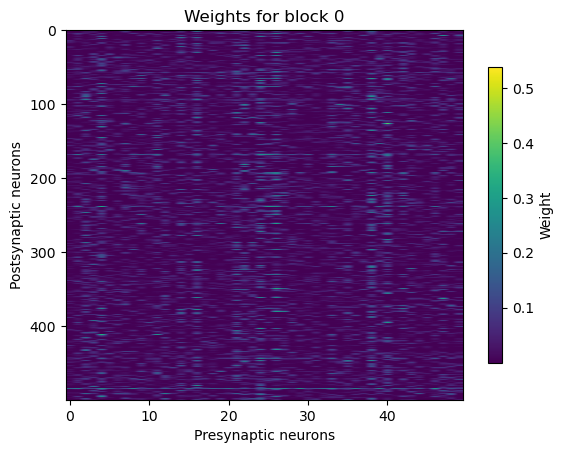

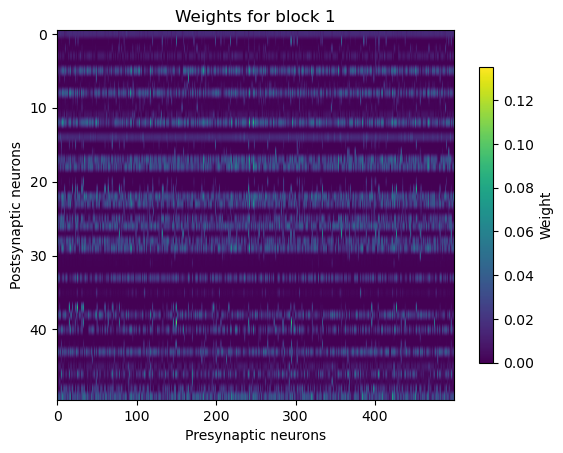

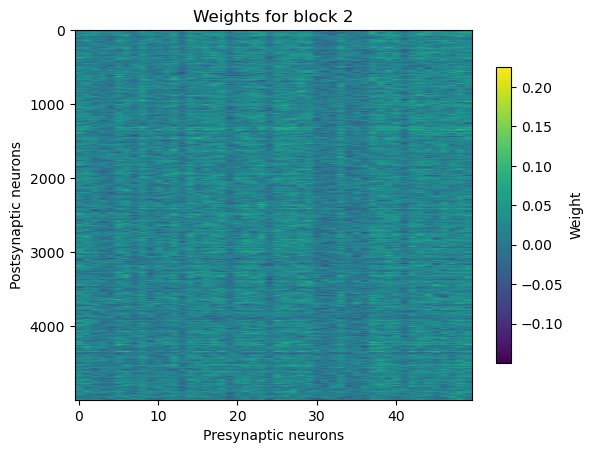

In [13]:
for i in range(len(layer_sizes)-1):
    hybrid_network.plot_weights(i)

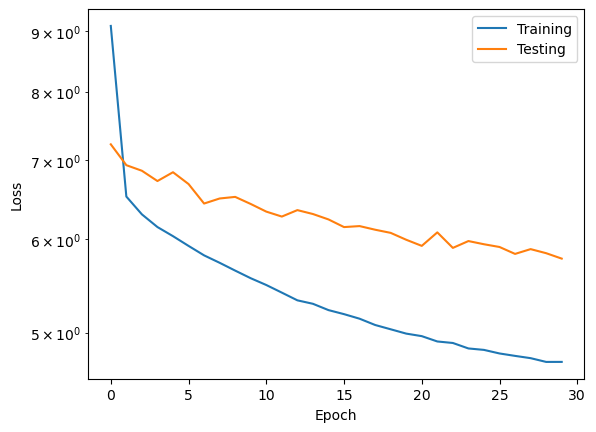

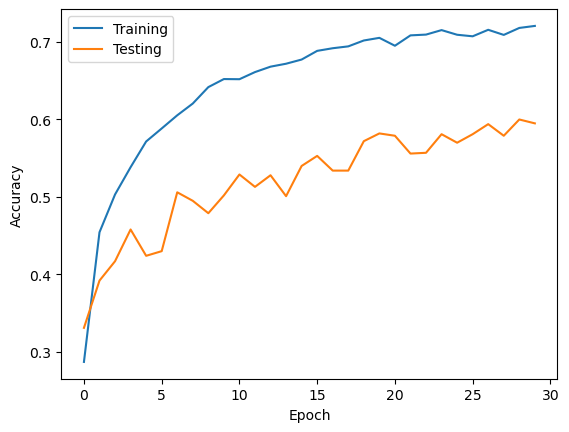

In [21]:
stats.plot(path=trained_folder+ "/")

## Inference with trained weights

In [31]:
# Loading the model
hybrid_network = HybridNetwork(
    layer_sizes, n_class, stdp_learning_rate, 
    stdp_tau_combined, train_hybrid=False, burn_in=50).to(device)

# SPECIFY THE EXACT NETWORK HERE.
hybrid_network.load_state_dict(torch.load(trained_folder + '/network.pt'))

# Retrieving one batch of testing examples
data, label = next(iter(testing_loader))
# Passing through the network and getting the readout of the last layer only
with torch.no_grad():
    readouts, _ = assistant.test(data, (one_hot(label.to(torch.int64), num_classes=n_class)))

# Softmaxing to get a probability distribution over all possible classes at 
# each timepoint, then finding the index of the largest probability value 
# for each timepoint, then finding the mode of these indices across all timepoints
values, _ = torch.mode(\
                torch.argmax(\
                    torch.nn.functional.softmax(\
                        readouts, dim=1), dim=1), dim=1)

print('Predictions:')
print(values.tolist()[0:20])
print('Ground truths')
print(label.tolist()[0:20])

Predictions:
[1, 0, 8, 8, 8, 1, 6, 5, 8, 0, 1, 1, 1, 8, 1, 3, 1, 1, 0, 8]
Ground truths
[5, 1, 8, 2, 6, 1, 4, 2, 7, 5, 2, 1, 1, 8, 5, 9, 3, 1, 4, 8]
